In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

from src.data.rgbd import load_rgbd
from src.data.pcd import load_pcd
from src.features.cropping import mask_selection_volume, box_mask_from_rgbd

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

o3d.visualization.webrtc_server.enable_webrtc()

[Open3D INFO] WebRTC GUI backend enabled.


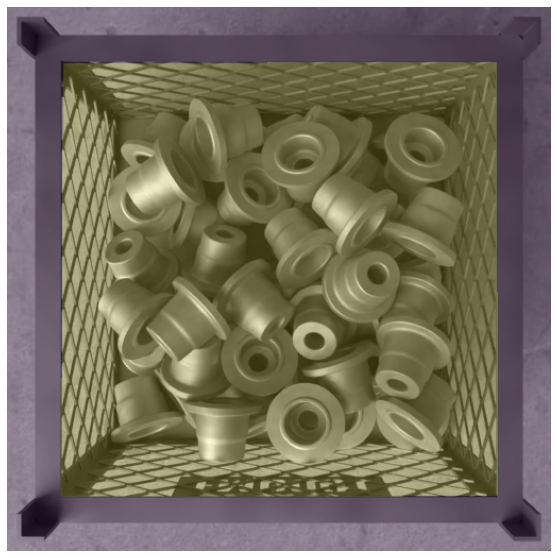

In [3]:
raw_data_dir = project_dir/'data/raw/render_results_imov_cam_mist_simple'

img_fpath = np.random.choice(list(raw_data_dir.glob('*/*.exr')))

rgbd = load_rgbd(img_fpath)

box_mask = box_mask_from_rgbd(rgbd)

plt.imshow(rgbd.color, cmap='gray')
plt.imshow(box_mask, alpha=0.2)
plt.gcf().set_size_inches(10,10)
plt.gca().set_axis_off()
plt.show()

In [4]:
vol = mask_selection_volume(rgbd, box_mask)

pcd = load_pcd(rgbd)

box = vol.crop_point_cloud(pcd)

box

PointCloud with 92422 points.

In [5]:
part_fpath = project_dir/'data/raw/part.stl'

part_mesh = o3d.io.read_triangle_mesh(str(part_fpath), enable_post_processing=True)

part_mesh.paint_uniform_color([1., 0., 0.,])

part = part_mesh.sample_points_uniformly(number_of_points=10000)

part_points = np.array(part.points) / 1000  # mm to meter conversion
part_points = part_points + np.array([0,0,0.3])
part_points = o3d.utility.Vector3dVector(part_points)
part.points = part_points

part

PointCloud with 10000 points.

In [6]:
def draw_registered(part, image, transformation):
    part_temp = deepcopy(part)
    part_temp.transform(transformation)
    
    o3d.visualization.draw([part_temp, image])

In [ ]:
trans_init = np.eye(4)

draw_registered(part, box, trans_init)

[Open3D INFO] Window window_2 created.
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.3270090431259607
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.3270090431259607
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.3270090431259607
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.3270090431259607
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call


[151:212][45050] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[151:280][45050] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[151:296][45050] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate[Open3D INFO] [Called HTTP API] /api/addIceCandidate

[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.06167898689755358
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.06167898689755358
[Open3D INFO] Sending init frames to window_0.
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getM

[192:632][45051] (stun_port.cc:96): Binding request timed out from 150.162.14.x:58364 (enp5s0)


# Feature extraction

In [7]:
box.estimate_normals()
box.orient_normals_towards_camera_location(np.array([0.,0.,2.]))

def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2

#     print(":: Estimate normal with search radius %.3f." % radius_normal)
#     pcd_down.estimate_normals(
#         o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30)
#     )

    radius_feature = voxel_size * 5
    
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100),
    )
    return pcd_down, pcd_fpfh

voxel_size = 0.01
part_down, part_fpfh = preprocess_point_cloud(part, voxel_size)
box_down, box_fpfh = preprocess_point_cloud(box, voxel_size)

part_fpfh

:: Downsample with a voxel size 0.010.
:: Compute FPFH feature with search radius 0.050.
:: Downsample with a voxel size 0.010.
:: Compute FPFH feature with search radius 0.050.


Feature class with dimension = 33 and num = 660
Access its data via data member.

In [8]:
box_fpfh

Feature class with dimension = 33 and num = 10461
Access its data via data member.

# RANSAC registration

In [69]:
# %%timeit

distance_threshold = voxel_size * 1.5
print(":: RANSAC registration on downsampled point clouds.")
print("   Since the downsampling voxel size is %.3f," % voxel_size)
print("   we use a liberal distance threshold %.3f." % distance_threshold)
reg = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    part_down, box_down, part_fpfh, box_fpfh, True,
    distance_threshold,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(True),
    3,
    [
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnNormal(np.pi/4),
    ],
    o3d.pipelines.registration.RANSACConvergenceCriteria(10000, 0.999),
)
reg

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.010,
   we use a liberal distance threshold 0.015.


RegistrationResult with fitness=4.878049e-02, inlier_rmse=4.388542e-17, and correspondence_set size of 2
Access transformation to get result.

[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.8035040592927978
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.8035040592927978
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.8035040592927978
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.8035040592927978
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.6262206637710952
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.6262206637710952
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.6262206637710952
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.6262206637710952
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D IN

[1185:577][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1185:585][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1185:608][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1185:620][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1185:621][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1185:740][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.0016558534068260577
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.0016558534068260577
[Open3D INFO] Sending init frames to window_8.
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call

[Open3D INFO] [Called HTTP API] /api/addIceCandidate


[1186:401][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1186:402][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1186:404][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1186:404][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[1186:405][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate[Open3D INFO] [Called HTTP API] /api/addIceCandidate

[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.9353257124122951
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.6328917079021117
[Open3D INFO] DataChannelObs

[1190:711][62485] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[1190:734][62485] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.


[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList


[1226:607][62485] (stun_port.cc:96): Binding request timed out from 150.162.14.x:34643 (enp5s0)


In [ ]:
7.317073e-02
6.450134e-03

In [54]:
draw_registered(part_down, box_down, reg.transformation)

[Open3D INFO] Window window_10 created.
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.3327076291025235
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.3327076291025235
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.3327076291025235
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.3327076291025235
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call


[947:405][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[947:474][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[947:561][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[947:596][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.26011771091972546
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.26011771091972546
[Open3D INFO] Sending init frames to window_8.
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call


[947:667][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[947:804][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate


[948:311][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[948:311][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[948:312][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[948:395][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.6385753691378193
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.6385753691378193
[Open3D INFO] Sending init frames to window_1.
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.5650546021651344
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.09093246720673975
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataCh

[950:308][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.1675084967651146
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.1675084967651146
[Open3D INFO] Sending init frames to window_9.
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /a

[954:110][62485] (dtls_transport.cc:529): DtlsTransport[0|1|__]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.


[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.5650546021651344
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.5650546021651344
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.5650546021651344
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.5650546021651344
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.5423595649376141
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.5423595649376141
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.5423595649376141
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.5423595649376141
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D

[956:831][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList


[960:540][62485] (stun_port.cc:308): Port[581bc350:0:1:0:local:Net[enp5s0:150.162.14.x/24:Unknown:id=1]]: UDP send of 1142 bytes failed with error 11
[960:540][62485] (stun_port.cc:308): Port[581bc350:0:1:0:local:Net[enp5s0:150.162.14.x/24:Unknown:id=1]]: UDP send of 1142 bytes failed with error 11
[960:540][62485] (stun_port.cc:308): Port[581bc350:0:1:0:local:Net[enp5s0:150.162.14.x/24:Unknown:id=1]]: UDP send of 1142 bytes failed with error 11
[960:540][62485] (stun_port.cc:308): Port[581bc350:0:1:0:local:Net[enp5s0:150.162.14.x/24:Unknown:id=1]]: UDP send of 1142 bytes failed with error 11
[960:540][62485] (stun_port.cc:308): Port[581bc350:0:1:0:local:Net[enp5s0:150.162.14.x/24:Unknown:id=1]]: UDP send of 1142 bytes failed with error 11
[960:540][62485] (stun_port.cc:308): Port[581bc350:0:1:0:local:Net[enp5s0:150.162.14.x/24:Unknown:id=1]]: UDP send of 1142 bytes failed with error 11
[960:540][62485] (stun_port.cc:308): Port[581bc350:0:1:0:local:Net[enp5s0:150.162.14.x/24:Unknown:id

[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.6262206637710952
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.6262206637710952
[Open3D INFO] Sending init frames to window_5.


[992:540][62485] (stun_port.cc:96): Binding request timed out from 150.162.14.x:46945 (enp5s0)
[1000:043][62485] (stun_port.cc:96): Binding request timed out from 150.162.14.x:34910 (enp5s0)


KeyboardInterrupt: 

In [10]:
draw_registered(part, box, reg.transformation)

[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC HTTP server handshake mode enabled.
[Open3D INFO] Open3D WebVisualizer is serving at http://150.162.14.54:8889.
[Open3D INFO] Set WEBRTC_IP and WEBRTC_PORT environment variable to customize the HTTP server address.
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call


[000:000][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.5936777909796893
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.5936777909796893
[Open3D INFO] Sending init frames to window_0.


KeyboardInterrupt: 

# Fast global registration

In [11]:
# %%timeit

distance_threshold = voxel_size * 0.5
# print(":: Apply fast global registration with distance threshold %.3f" % distance_threshold)
fast_reg = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
    part_down, box_down, part_fpfh, box_fpfh,
    o3d.pipelines.registration.FastGlobalRegistrationOption(maximum_correspondence_distance=distance_threshold),
)
fast_reg

RegistrationResult with fitness=9.393939e-02, inlier_rmse=3.892298e-03, and correspondence_set size of 62
Access transformation to get result.

In [12]:
draw_registered(part, box, fast_reg.transformation)

[Open3D INFO] Window window_1 created.
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.5936777909796893
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.5936777909796893
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.5936777909796893
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.5936777909796893
[Open3D INFO] [Called HTTP API] /api/hangup[Open3D INFO] [Called HTTP API] /api/getMediaList

[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call


[030:549][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[030:639][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.16154177057597052
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.16154177057597052
[Open3D INFO] Sending init frames to window_1.
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/hangup


KeyboardInterrupt: 

# ICP test

In [33]:
%%time

max_correspondence_distance = 10 * voxel_size
estimation = o3d.pipelines.registration.TransformationEstimationPointToPlane()

criteria = o3d.pipelines.registration.ICPConvergenceCriteria(
    relative_fitness=0.0000001,
    relative_rmse=0.000001,
    max_iteration=1000
)

registration_icp = o3d.pipelines.registration.registration_icp(
    part,
    box,
    max_correspondence_distance,
    reg.transformation,
    estimation,
    criteria
)

print("Inlier Fitness: ", registration_icp.fitness)
print("Inlier RMSE: ", registration_icp.inlier_rmse)

Inlier Fitness:  1.0
Inlier RMSE:  0.01076457333978091
CPU times: user 728 ms, sys: 163 ms, total: 891 ms
Wall time: 192 ms


In [34]:
draw_registered(part, box, registration_icp.transformation)

[Open3D INFO] Window window_5 created.
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.36035880053942315
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.36035880053942315
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.36035880053942315
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.36035880053942315
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/getIceServers


[225:205][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[225:283][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call


[225:431][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[225:504][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[225:556][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[225:648][62481] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.03759736878072628
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.03759736878072628
[Open3D INFO] Sending init frames to window_5.
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] 

[230:934][62485] (stun_port.cc:96): Binding request timed out from 150.162.14.x:47466 (enp5s0)
[230:934][62485] (dtls_transport.cc:529): DtlsTransport[0|1|__]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.


[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList


KeyboardInterrupt: 